In [74]:
import datetime
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss, roc_auc_score
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('./data.csv')
data = data.drop(columns = ['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'])
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0,1,1


In [7]:
data.describe()

,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
count,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,15821472.0,1.582147e+07
mean,8.152679e+01,3.816483e+02,6.238540e-01,1.840605e+00,4.346986e+00,1.0,2.668835e-02
std,1.632448e+02,3.959386e+02,9.249152e+00,1.530005e+00,4.317701e+00,0.0,1.611710e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00
25%,1.400000e+01,5.200000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000e+00
50%,1.900000e+01,2.170000e+02,0.000000e+00,2.000000e+00,4.000000e+00,1.0,0.000000e+00
75%,6.000000e+01,6.110000e+02,0.000000e+00,3.000000e+00,7.000000e+00,1.0,0.000000e+00
max,3.443000e+03,1.632000e+03,8.290000e+02,1.000000e+01,1.600000e+01,1.0,1.000000e+00


In [9]:
data.dtypes()

date_time          object
zone_id             int64
banner_id           int64
campaign_clicks     int64
os_id               int64
country_id          int64
impressions         int64
clicks              int64
dtype: object

In [11]:
def analysis(data: pd.DataFrame):
    print("NA count ", data.isna().sum().sum())
    print(data['zone_id'].value_counts())
    print(data['banner_id'].value_counts())
    print(data['campaign_clicks'].value_counts())
    print(data['os_id'].value_counts())
    print(data['country_id'].value_counts())
    print(data['impressions'].value_counts())
    print(data['clicks'].value_counts())
analysis(data)

NA count  0
17      2280422
14      1638642
12       736352
0        708379
19       693292
         ...   
2186          1
2188          1
2518          1
2962          1
3443          1
Name: zone_id, Length: 3444, dtype: int64
22      613367
361     387563
3       286999
18      262946
21      246378
         ...  
1501         1
1503         1
1504         1
1507         1
1632         1
Name: banner_id, Length: 1633, dtype: int64
0      13682452
1       1236822
2        342937
3        173528
4        100293
         ...   
791           1
829           1
820           1
803           1
828           1
Name: campaign_clicks, Length: 822, dtype: int64
2     4589979
0     3856798
1     3178693
4     3012541
3      759767
6      310346
5      111946
8        1273
7          99
9          25
10          5
Name: os_id, dtype: int64
0     4956393
5     1910054
6     1582705
7     1525569
1     1346321
3     1337392
15     603301
12     478038
9      439004
4      388801
10     356490
11

- Нету Nan
- колонка `impressions` не несет информации, можно удалить

In [29]:
data = data.drop('impressions', axis=1)

Разделим дату и время и посмотрим как они устроены. 

In [27]:
data['date_time'] = pd.to_datetime(data['date_time'])
data['time'] = data['date_time'].dt.time
data['date'] = data['date_time'].dt.date

In [30]:
data['date'].unique()

array([datetime.date(2021, 9, 27), datetime.date(2021, 9, 26),
       datetime.date(2021, 9, 29), datetime.date(2021, 9, 30),
       datetime.date(2021, 9, 28), datetime.date(2021, 10, 1),
       datetime.date(2021, 10, 2), datetime.date(2021, 9, 1)],
      dtype=object)

In [31]:
data['date'].value_counts()

2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
2021-09-01          1
Name: date, dtype: int64

`2021-10-02` -- последняя дата, будем использовать для тестового множества

In [41]:
data['time'].unique().shape

(86400,)

Оставим от времени только час, а от даты только день недели

In [43]:
data['hour'] = data['date_time'].dt.hour
data['day'] = data['date_time'].dt.dayofweek

In [44]:
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks,time,date,hour,day
0,2021-09-27 00:01:30,0,0,0,0,0,1,00:01:30,2021-09-27,0,0
1,2021-09-26 22:54:49,1,1,0,0,1,1,22:54:49,2021-09-26,22,6
2,2021-09-26 23:57:20,2,2,3,0,0,1,23:57:20,2021-09-26,23,6
3,2021-09-27 00:04:30,3,3,0,1,1,1,00:04:30,2021-09-27,0,0
4,2021-09-27 00:06:21,4,4,0,1,0,1,00:06:21,2021-09-27,0,0


<Axes: ylabel='Frequency'>

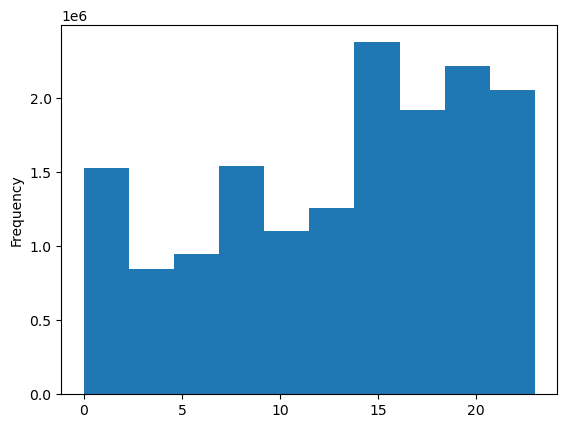

In [45]:
data['hour'].plot.hist()

In [63]:
# feature_engineering
data.drop(columns = ['date_time', 'time'])
split_date = datetime.date(2021, 10, 2)
train = data[data['date'] != split_date]
test = data[data['date'] == split_date]
print(train.shape, test.shape)
X_train = train[['zone_id','banner_id','campaign_clicks','os_id','country_id','hour', 'day']].values
X_test = test[['zone_id','banner_id','campaign_clicks','os_id','country_id','hour', 'day']].values
y_train = train['clicks'].values
y_test = test['clicks'].values

(13692494, 11) (2128978, 11)


In [64]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

In [66]:
def create_model(X, y, c):
    return LogisticRegression(solver='liblinear', penalty='l2', C=c).fit(X, y)

Посчитаем бейзлайн и обучим линейные модели с разным параметром l2 регуляризации

In [92]:
p_mean = y_train.mean()
log_loss_baseline = log_loss(y_test, [p_mean] * len(y_test))
auc_baseline = roc_auc_score(y_test, [p_mean] * len(y_test))

print(f'log-loss Baseline: {log_loss_baseline}')
print(f'AUC Baseline     : {auc_baseline}')

log-loss Baseline: 0.15486198009919555
AUC Baseline     : 0.5


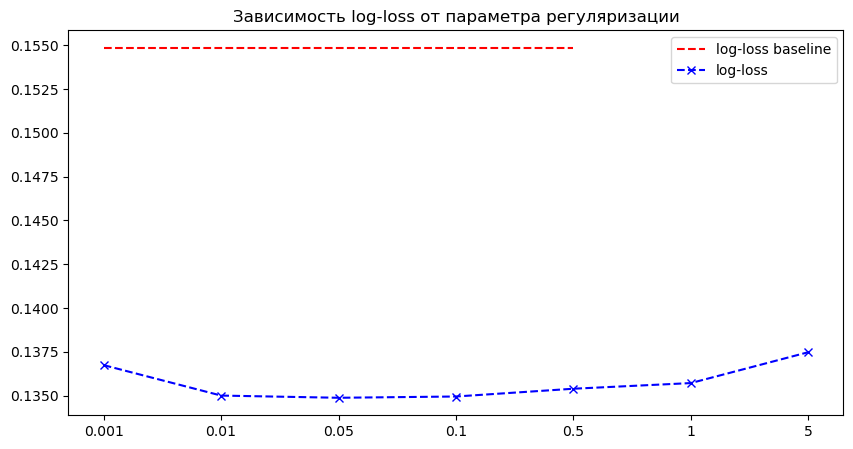

In [91]:
coefs = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5]
log_losses = [0] * 7
aucs = [0] * 7


for i in range(len(coefs)):
    model = create_model(X_train, y_train, coefs[i])
    pred = model.predict_proba(X_test)
    log_losses[i] = log_loss(y_test, pred)
    aucs[i] = roc_auc_score(y_test, pred[:, 1])

plt.figure(figsize=(10, 5))
plt.hlines(y=log_loss_baseline, xmin=0, xmax=len(C) - 1, linestyle='--', color='r', label='log-loss baseline')
plt.plot(log_losses, marker='x', linestyle='--', color='b', label='log-loss') 
plt.xticks(ticks=range(7), labels=coefs)
plt.title('Зависимость log-loss от параметра регуляризации')
plt.legend()
plt.show()

In [93]:
best_i = np.argmin(log_losses)
print(f"Best c = {coefs[best_i]}")

Best c = 0.05


Лучшей модели соответствует коэф. регуляризации c = 0.05

Итоговые метрики для лучшей модели

In [94]:
print("Best log-loss:", log_losses[i])
print("Best AUC:", aucs[i])

Best log-loss: 0.13747519259207744
Best AUC: 0.7796807826344679
